In [1]:
import os
from typing import Any, Dict, Optional
import pandas as pd
import pytz
from datetime import datetime, timedelta
from dotenv import load_dotenv
from tinkoff.invest import Client, CandleInterval
from dotenv import load_dotenv
import requests
import numpy as np

try:
    import xgboost as xgb
except ImportError:
    xgb = None  # type: ignore

try:
    import torch
    from torch import nn
    from torchvision import transforms
except ImportError:
    torch = None  # type: ignore

try:
    import timm
except ImportError:
    timm = None  # type: ignore

try:
    import mplfinance as mpf
    import matplotlib.pyplot as plt
except ImportError:
    mpf = None  # type: ignore

try:
    import pytz
except ImportError:
    pytz = None  # type: ignore


In [2]:
import os
import pandas as pd
import pytz
from datetime import datetime, timedelta
from dotenv import load_dotenv
from tinkoff.invest import Client, CandleInterval

# === Настройки ===
load_dotenv()
TOKEN = os.getenv("TINKOFF_TOKEN")
TICKER = "SBER"
DAYS = 5
TIMEFRAME = CandleInterval.CANDLE_INTERVAL_5_MIN
TZ = pytz.timezone("Europe/Moscow")

if not TOKEN:
    raise RuntimeError("❌ В .env не найден TINKOFF_TOKEN")

def fetch_tinkoff_candles(token: str, ticker: str, days: int = 1, interval=TIMEFRAME):
    from tinkoff.invest.services import InstrumentsService
    from tinkoff.invest.utils import now

    with Client(token) as client:
        # Получаем FIGI по тикеру
        instruments: InstrumentsService = client.instruments
        shares = instruments.shares().instruments
        figi = None
        for share in shares:
            if share.ticker.upper() == ticker.upper():
                figi = share.figi
                break
        if not figi:
            raise RuntimeError(f"FIGI для {ticker} не найден")

        # Получаем свечи
        end = now()
        start = end - timedelta(days=days)
        candles = client.get_all_candles(
            figi=figi,
            from_=start,
            to=end,
            interval=interval,
        )

        data = []
        for candle in candles:
            data.append({
                "time": candle.time.astimezone(TZ),
                "open": candle.open.units + candle.open.nano / 1e9,
                "high": candle.high.units + candle.high.nano / 1e9,
                "low": candle.low.units + candle.low.nano / 1e9,
                "close": candle.close.units + candle.close.nano / 1e9,
                "volume": candle.volume,
            })

        df = pd.DataFrame(data)
        return df

# === Проверка ===
print("🔑 Проверка токена и загрузка данных из Tinkoff API…")
try:
    print(TOKEN)
    df = fetch_tinkoff_candles(TOKEN, TICKER, days=DAYS)
    print(f"✅ Успешно: {len(df)} свечей загружено")
    print(df.tail(5))
except Exception as e:
    print("❌ Ошибка:", e)


🔑 Проверка токена и загрузка данных из Tinkoff API…
t.1ZnhEdqK3HfqGo0yI37OGoE0EqIERzt20FFqYtDUXmlzkqFE7i9ZrE6xz_rljtA4iidBqVj7OjWqbj2e78MVCA
✅ Успешно: 1001 свечей загружено
                          time    open    high     low   close  volume
996  2025-11-01 11:05:00+03:00  294.04  294.04  293.85  293.90   67940
997  2025-11-01 11:10:00+03:00  293.90  293.90  293.76  293.86   73735
998  2025-11-01 11:15:00+03:00  293.84  293.87  293.71  293.86   63910
999  2025-11-01 11:20:00+03:00  293.84  293.94  293.84  293.90   75632
1000 2025-11-01 11:25:00+03:00  293.90  294.25  293.89  294.10  140954


In [3]:
def compute_ml_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute ML model features on a DataFrame of candles.

    The training script uses the following features:
    - ret_1: previous log return
    - sma_3, sma_5, sma_10: simple moving averages of 'close'
    - std_3, std_5, std_10: rolling standard deviations of log returns
    - atr_14: Average True Range over 14 periods (simplified)

    Parameters
    ----------
    df : pd.DataFrame
        Candle data sorted by time with columns ["time", "open", "high", "low", "close", "volume"].

    Returns
    -------
    pd.DataFrame
        DataFrame containing the computed feature columns.
    """
    df = df.copy().reset_index(drop=True)
    df["close"] = df["close"].astype(float)
    df["logret"] = np.log(df["close"]).diff()
    df["ret_1"] = df["logret"].shift(1)
    for w in [3, 5, 10]:
        df[f"sma_{w}"] = df["close"].rolling(window=w).mean()
        df[f"std_{w}"] = df["logret"].rolling(window=w).std()
    # True range components
    df["high"] = df["high"].astype(float)
    df["low"] = df["low"].astype(float)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - df["close"].shift(1)).abs()
    tr3 = (df["low"] - df["close"].shift(1)).abs()
    df["tr"] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df["atr_14"] = df["tr"].rolling(14).mean()
    feats = ["ret_1", "sma_3", "sma_5", "sma_10", "std_3", "std_5", "std_10", "atr_14"]
    return df[feats]


In [4]:
def predict_ml(
    model: xgb.Booster,
    feats_df: pd.DataFrame,
    return_proba: bool = True,
) -> Dict[str, Any]:
    """Run ML model inference on feature DataFrame.

    Parameters
    ----------
    model : xgb.Booster
        Loaded XGBoost model.
    feats_df : pd.DataFrame
        DataFrame of features with rows corresponding to time steps.
    return_proba : bool
        Whether to return class probabilities along with predicted labels.

    Returns
    -------
    dict
        Contains keys ``"labels"`` (list of str), ``"indices"`` (list of int),
        and optionally ``"proba"`` (np.ndarray of shape (n_samples, 3)).
    """
    dmatrix = xgb.DMatrix(feats_df)
    probs = model.predict(dmatrix)  # shape (n_samples, num_classes)
    preds = np.argmax(probs, axis=1)
    idx_to_label = {0: "down", 1: "flat", 2: "up"}
    labels = [idx_to_label.get(int(i), str(i)) for i in preds]
    result = {"indices": preds.tolist(), "labels": labels}
    if return_proba:
        result["proba"] = probs
    return result


In [5]:
import xgboost as xgb

def load_xgb_model(model_path: str) -> xgb.Booster:
    """Load a saved XGBoost model from file."""
    try:
        if xgb is None:
            raise ImportError(
                "xgboost is not installed. Install it via `pip install xgboost` to "
                "use the ML inference pipeline."
            )
        booster = xgb.Booster()
        booster.load_model(model_path)
    except Exception as e:
        import joblib
        booster = joblib.load("xgb_sber.model")
    return booster

In [6]:
def add_cv_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute technical indicators needed for candlestick chart rendering.

    Adds exponential moving averages (ema_10, ema_20) and Bollinger bands
    (boll_up, boll_low).  If these columns already exist they will be
    overwritten.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with at least a "close" column.

    Returns
    -------
    pd.DataFrame
        DataFrame with new columns ["ema_10", "ema_20", "boll_up", "boll_low"].
    """
    df = df.copy()
    df["ema_10"] = df["close"].ewm(span=10).mean()
    df["ema_20"] = df["close"].ewm(span=20).mean()
    mid = df["close"].rolling(20).mean()
    std = df["close"].rolling(20).std()
    df["boll_up"] = mid + 2 * std
    df["boll_low"] = mid - 2 * std
    return df


In [7]:
def render_candle_image(
    sub_df: pd.DataFrame,
    img_size: tuple = (8, 4),
    dpi: int = 100,
    use_jpg: bool = True,
    style: Optional[Any] = None,
) -> np.ndarray:
    """Render a single candlestick window into a NumPy RGB image.

    Parameters
    ----------
    sub_df : pd.DataFrame
        Subset of candle data covering the lookback window.  Must have index
        as datetime and columns open/high/low/close/volume along with
        optional ema_10, ema_20, boll_up, boll_low for overlay.
    img_size : tuple
        Figure size in inches (width, height).
    dpi : int
        Dots per inch for the figure.
    use_jpg : bool
        If True the image background is black; otherwise PNG with alpha.
    style : Optional
        mplfinance style to use.  If None, a night/clouds style is created
        similar to training.

    Returns
    -------
    np.ndarray
        Image as a HxWx3 uint8 array.
    """
    if mpf is None or plt is None:
        raise ImportError(
            "mplfinance and matplotlib must be installed to render candle images; "
            "install them via `pip install mplfinance matplotlib`"
        )
    # Default style matching the training notebook
    if style is None:
        mc = mpf.make_marketcolors(up="lime", down="red", edge="white", wick="white", volume="gray")
        style = mpf.make_mpf_style(
            base_mpf_style="nightclouds",
            facecolor="black",
            edgecolor="white",
            marketcolors=mc,
            rc={"axes.labelcolor": "white", "axes.edgecolor": "white"},
        )
    # Create figure and axes via mpf.plot and retrieve figure
    fig, axes = mpf.plot(
        sub_df,
        type="candle",
        style=style,
        volume=True,
        figsize=img_size,
        tight_layout=True,
        show_nontrading=True,
        returnfig=True,
    )
    # Remove axis details
    for ax in axes:
        ax.set_axis_off()
        ax.grid(False)
    # Overlay EMA and Bollinger if present
    if "ema_10" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_10"], color="deepskyblue", linewidth=1)
    if "ema_20" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_20"], color="orange", linewidth=1)
    if {"boll_up", "boll_low"}.issubset(sub_df.columns):
        axes[0].plot(sub_df.index, sub_df["boll_up"], color="gray", linestyle="--", linewidth=0.8)
        axes[0].plot(sub_df.index, sub_df["boll_low"], color="gray", linestyle="--", linewidth=0.8)
    # Draw to numpy array
    fig.canvas.draw()
    # img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    # img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    # plt.close(fig)
    buf = fig.canvas.buffer_rgba()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(buf, dtype=np.uint8).reshape((h, w, 4))[..., :3]  # drop alpha
    plt.close(fig)
    return img


In [8]:
def prepare_cv_tensor(img: np.ndarray) -> torch.Tensor:
    """Convert an RGB image array into a Torch tensor with normalization.

    The normalization parameters match those used during training.

    Parameters
    ----------
    img : np.ndarray
        Image array with shape (H, W, 3) and dtype uint8.

    Returns
    -------
    torch.Tensor
        Tensor of shape (3, 224, 224) normalized for ConvNeXt.
    """
    if torch is None:
        raise ImportError(
            "torch must be installed to prepare image tensors; "
            "install it via `pip install torch torchvision`"
        )
    # Define the same transforms as in training
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    return transform(img).unsqueeze(0)  # add batch dimension


In [9]:
import json

def load_cv_model(meta_path: str, model_path: str, device: Optional[str] = None) -> nn.Module:
    """Reconstruct and load the CV model from saved state.

    Parameters
    ----------
    meta_path : str
        Path to meta.json file containing label_to_idx and model_name.
    model_path : str
        Path to the saved PyTorch checkpoint (state_dict).
    device : Optional[str]
        Device string (e.g. "cuda" or "cpu"); if None, will auto-detect.

    Returns
    -------
    torch.nn.Module
        Loaded model in evaluation mode.
    """
    if timm is None or torch is None:
        raise ImportError(
            "Both timm and torch must be installed to load the CV model; "
            "install via `pip install timm torch torchvision`"
        )
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    label_to_idx: Dict[str, int] = meta["label_to_idx"]
    model_name: str = meta.get("model_name", "convnext_tiny")
    num_classes = len(label_to_idx)
    # Construct backbone
    backbone = timm.create_model(model_name, pretrained=False, num_classes=0, global_pool="avg")
    feat_dim = backbone.num_features  # type: ignore[attr-defined]
    # Define head exactly as in training
    head = nn.Sequential(
        nn.Linear(feat_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )
    model = nn.Sequential(backbone, head)
    # Load weights
    checkpoint = torch.load(model_path, map_location=device)
    if "model_state" in checkpoint:
        state_dict = checkpoint["model_state"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model


In [10]:
def predict_cv(
    model: nn.Module,
    img_tensor: torch.Tensor,
    meta_path: str,
    device: Optional[str] = None,
    return_proba: bool = True,
) -> Dict[str, Any]:
    """Run the CV model on a single image tensor.

    Parameters
    ----------
    model : nn.Module
        Loaded CV model.
    img_tensor : torch.Tensor
        4D tensor (batch_size=1) representing the image.
    meta_path : str
        Path to meta.json to map indices back to labels.
    device : Optional[str]
        Device string ("cuda" or "cpu"); if None, automatically detected.
    return_proba : bool
        Whether to include probabilities in the result.

    Returns
    -------
    dict
        Contains keys ``"indices"`` (list of predicted indices), ``"labels"``
        (list of string labels), and optionally ``"proba"`` (np.ndarray).
    """
    if torch is None:
        raise ImportError("torch must be installed to perform CV inference")
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).cpu().numpy()
        probs_np = probs.cpu().numpy()
    # Load meta to map indices back to labels
    with open(meta_path, "r") as f:
        meta = json.load(f)
    idx_to_label = {v: k for k, v in meta["label_to_idx"].items()}
    labels = [idx_to_label.get(int(i), str(i)) for i in pred_idx]
    result = {"indices": pred_idx.tolist(), "labels": labels}
    if return_proba:
        result["proba"] = probs_np
    return result


In [11]:
def run_full_inference(
    ticker: str = "SBER",
    tf: str = "5m",
    days: int = 1,
    lookback: int = 60,
    ml_model_path: str = "xgb_sber.model",
    cv_model_path: str = "best_model.pth",
    meta_path: str = "meta.json",
    token: str = TOKEN,
    tz_name: str = "Europe/Amsterdam",
) -> Dict[str, Any]:
    """Run both the ML and CV models on the most recent candle data.

    Parameters
    ----------
    ticker : str
        Ticker symbol ("SBER" for Tinkoff, "SBER.ME" for Yahoo).  If no
        exchange suffix is provided for Yahoo, ".ME" is appended.
    tf : str
        Candle timeframe ("5m", "15m", etc.).
    start_date : Optional[str]
        If provided, overrides ``days`` and ``end_date``.  ISO date string.
    end_date : Optional[str]
        End date for fetching candles.  If None, uses current date.
    days : int
        Number of days of history to fetch when start_date is not given.
    lookback : int
        Number of candles to include in the CV model window.
    ml_model_path : str
        Path to saved XGBoost model (binary .model file).
    cv_model_path : str
        Path to saved PyTorch model (checkpoint from training).
    meta_path : str
        Path to meta.json containing the CV label mapping and backbone name.
    token : Optional[str]
        Tinkoff API token.  If None or empty, Yahoo Finance is used.
    tz_name : str
        Local timezone for candle timestamps and "now" determination.

    Returns
    -------
    dict
        Contains keys ``"ml_preds"`` and ``"cv_preds"`` with prediction
        dictionaries from each model.  Each dictionary contains indices,
        labels and (optionally) probabilities.
    """
    # Determine fetch range
    # Use days lookback from now
    df_candles = fetch_tinkoff_candles(token, ticker, days=DAYS)
    if df_candles.empty:
        raise RuntimeError("No candle data available for inference")
    # Sort by time just in case
    df_candles = df_candles.sort_values("time").reset_index(drop=True)

    # -----------------------------------------------------------------------
    # ML inference
    # -----------------------------------------------------------------------
    ml_model = load_xgb_model(ml_model_path)
    feats_df = compute_ml_features(df_candles).dropna()
    # Align features with candle timestamps (drop NaN rows resets index)
    ml_result = predict_ml(ml_model, feats_df, return_proba=True)

    # -----------------------------------------------------------------------
    # CV inference
    # -----------------------------------------------------------------------
    # Compute technical indicators needed for rendering
    df_feat = add_cv_features(df_candles)
    # Use the last ``lookback`` candles for the CV sample
    if len(df_feat) < lookback:
        raise ValueError(
            f"Not enough candles ({len(df_feat)}) for lookback={lookback}. "
            "Increase history length or decrease lookback."
        )
    sub = df_feat.iloc[-lookback:].copy()
    # Prepare index for mplfinance (datatime index required)
    sub["time"] = pd.to_datetime(sub["time"])
    sub = sub.set_index("time")
    # Render image to numpy array
    img = render_candle_image(sub, img_size=(8, 4), dpi=100, use_jpg=True)
    # Convert to tensor for model
    img_tensor = prepare_cv_tensor(img)
    # Load model
    cv_model = load_cv_model(meta_path, cv_model_path)
    # Run prediction
    cv_result = predict_cv(cv_model, img_tensor, meta_path, return_proba=True)

    return {"ml_preds": ml_result, "cv_preds": cv_result}


In [ ]:
import time

load_dotenv()
TOKEN = os.getenv("TINKOFF_TOKEN")
TICKER = "SBER"
DAYS = 5
TIMEFRAME = CandleInterval.CANDLE_INTERVAL_5_MIN
TZ = pytz.timezone("Europe/Moscow")
LOOKBACK = 60
ml_model = "xgb_sber.model"
cv_model = "best_model.pth"
meta = "meta.json"

while True:
    results = run_full_inference(
            ticker=TICKER,
            tf=TIMEFRAME,
            days=DAYS,
            lookback=LOOKBACK,
            ml_model_path=ml_model,
            cv_model_path=cv_model,
            meta_path=meta,
            token=TOKEN,
        )
    print("ML predictions:", results["ml_preds"]['indices'][-1], results["ml_preds"]['labels'][-1], results["ml_preds"]['proba'][-1])
    print("CV predictions:", results["cv_preds"]['indices'][-1], results["cv_preds"]['labels'][-1], results["cv_preds"]['proba'][-1])
    time.sleep(300)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:27:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.36888108 0.25138822 0.37973076]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.3827328 , 0.14819682, 0.46907037]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:32:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.49168503 0.24724777 0.26106718]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.3807363 , 0.15037827, 0.46888542]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:37:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.49644706 0.2795095  0.22404341]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.38555738, 0.11858727, 0.4958554 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.47923285 0.3029221  0.21784505]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.36645204, 0.10234248, 0.5312055 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:47:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.3325352  0.25386366 0.41360116]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.38728657, 0.09379412, 0.51891935]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:53:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.35162926 0.23824592 0.41012484]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.38752276, 0.10175522, 0.510722  ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [11:58:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.45210674 0.2555685  0.29232475]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.40520915, 0.09389599, 0.5008949 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:03:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.3353307  0.2365759  0.42809337]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.39361557, 0.10495825, 0.50142616]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:08:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.32593903 0.28839388 0.3856671 ]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.3958275 , 0.10130783, 0.5028647 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:13:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.35428402 0.31347382 0.33224213]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.39943284, 0.11302181, 0.48754537]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:18:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.35023597 0.25180495 0.3979591 ]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.39309886, 0.10901391, 0.49788728]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.44126022 0.23228198 0.32645783]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.39001718, 0.09833904, 0.51164377]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:28:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.35335243 0.21892662 0.427721  ]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.39063713, 0.09672318, 0.51263976]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:33:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.26591936 0.26765844 0.46642226]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.37242365, 0.11818688, 0.5093895 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:38:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 0 down [0.3980184  0.25021857 0.351763  ]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.3776935 , 0.12267382, 0.4996327 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:43:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.3580475  0.25907993 0.3828726 ]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.34235695, 0.14682692, 0.5108161 ]], dtype=float32)}


C:\Users\Admin\AppData\Local\Temp\ipykernel_15808\1009136000.py:12: UserWarning: [12:48:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model(model_path)


ML predictions: 2 up [0.31043437 0.27085495 0.41871065]
CV predictions: {'indices': [2], 'labels': ['up'], 'proba': array([[0.3689741 , 0.12223432, 0.50879157]], dtype=float32)}


Стохастика

In [8]:
%pip -q install hmmlearn arch statsmodels pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from hmmlearn.hmm import GaussianHMM
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)
np.random.seed(42)


In [35]:
# ========= ПАРАМЕТРЫ =========
H            = 3        # ваш горизонт (как в таргете)
BASE_THR     = 0.53     # базовый порог уверенности proba_up
MARGIN_HIT   = 0.05     # на сколько p_hit_tp должно превосходить p_hit_sl
VOL_PCTL_ABS = 0.95     # пратежка: не торговать в топ-5% волатильности
TARGET_VOL   = 0.02     # дневной таргет под волатильность (пример)
F_MAX        = 0.02     # максимум доля капитала (ограничитель Келли)
TP_ATR_K     = 2      # базовый множитель ATR на TP (как в baseline)
SL_ATR_K     = 1      # базовый множитель ATR на SL (как в baseline)
# =============================


In [36]:
def compute_atr_wilder(df, n=14):
    """True Range + Wilder's ATR, если нет atr_14 в CSV."""
    high = df['high'].astype(float)
    low  = df['low'].astype(float)
    close= df['close'].astype(float)
    prev_close = close.shift(1)

    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low  - prev_close).abs()
    tr  = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.ewm(alpha=1/n, adjust=False).mean()
    return atr

def fit_hmm_regimes(returns, n_states=2):
    X = returns.dropna().values.reshape(-1,1)
    if len(X) < 200:  # минимально, чтобы стабильно
        return None, None
    hmm = GaussianHMM(n_components=n_states, covariance_type='full',
                      n_iter=200, random_state=42)
    hmm.fit(X)
    hidden = pd.Series(hmm.predict(X), index=returns.dropna().index)
    return hmm, hidden.reindex(returns.index)

def garch_sigma(returns):
    # Еженаборная оценка σ_t через (E)GARCH: используем простой GARCH(1,1)
    r = (returns.dropna()*100).astype(float)  # проценты
    if len(r) < 300:
        return returns.abs().rolling(20).std().reindex(returns.index)
    am = arch_model(r, p=1, q=1, mean='Constant', vol='GARCH', dist='normal')
    res = am.fit(disp="off")
    cond_vol = res.conditional_volatility / 100.0  # обратно в доли
    return cond_vol.reindex(returns.index)

def arima_sign(returns):
    # Одношаговый ARIMA sanity-check (легкий)
    y = returns.dropna()
    if len(y) < 100:
        return pd.Series(index=returns.index, dtype=float)
    model = ARIMA(y, order=(1,0,1))
    res = model.fit()
    fc = res.forecast(1)
    sgn = np.sign(fc.iloc[0])
    return pd.Series(sgn, index=returns.index).ffill()

def mc_hit_probs(close_series, mu, sigma, H, n_paths=2000, dt=1):
    # Упрощенный GBM для hit-prob: вернём массив максимумов/минимумов за H шагов
    S0 = close_series.iloc[-1]
    z = np.random.normal(size=(n_paths, H))
    steps = (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
    paths = S0 * np.exp(np.cumsum(steps, axis=1))
    max_arr = paths.max(axis=1)
    min_arr = paths.min(axis=1)
    return max_arr, min_arr

def kelly_lite(prob_up, R=1.0, f_max=F_MAX):
    p = np.clip(prob_up, 1e-6, 1-1e-6)
    f = (p*R - (1-p))/R
    return float(np.clip(f, 0.0, f_max))

def overlays_postprocess(df):
    """
    На вход: DataFrame со столбцами:
      time(datetime), close, high, low, (atr_14 optional), (proba_up | pred_class)
    На выход: тот же DF + signal, tp_price, sl_price, size
    """
    df = df.sort_values('time').reset_index(drop=True).copy()

    assert {'close','high','low'}.issubset(df.columns), "Нужны колонки close/high/low"

    if ('proba_up' not in df.columns) and ('pred_class' not in df.columns):
        raise ValueError("Добавьте в входной набор либо 'proba_up', либо 'pred_class' из вашей модели.")

    if 'atr_14' not in df.columns:
        df['atr_14'] = compute_atr_wilder(df, n=14)

    df['logret'] = np.log(df['close']).diff()

    # --- 1) HMM режимы ---
    hmm, regimes = fit_hmm_regimes(df['logret'])
    df['regime'] = regimes  # 0/1; если None, будет NaN -> отключим фильтр

    # --- 2) GARCH sigma ---
    df['sigma_t'] = garch_sigma(df['logret'])
    vol_cut = df['sigma_t'].quantile(VOL_PCTL_ABS)

    # --- 3) ARIMA sanity sign ---
    df['arima_sign'] = arima_sign(df['logret'])

    # Базовая уверенность
    if 'proba_up' not in df.columns:
        # Если только класс, делаем мягкую суррогатную уверенность
        df['proba_up'] = (df['pred_class'] == 2).astype(float) * 0.6 + 0.2

    # Инициализация выходов
    out = []
    for i in range(len(df)):
        row = df.iloc[i]
        # Пропуски на ранних шагах
        if i < 50 or np.isnan(row['logret']):
            out.append((0, np.nan, np.nan, 0.0))  # no trade
            continue

        # Базовый сигнал: long если proba_up ≥ BASE_THR
        # (оставлено для ясности; реально используем take_long ниже)
        _base_long = (row['proba_up'] >= BASE_THR)

        # Фильтр 1: волатильность (абстейн при сверх-воле)
        if not np.isnan(row['sigma_t']) and row['sigma_t'] >= vol_cut:
            out.append((0, np.nan, np.nan, 0.0))
            continue

        # Фильтр 2: режим (если определён и «плохой» — повышаем порог)
        thr = BASE_THR
        if not np.isnan(row['regime']):
            if int(row['regime']) == 1:     # условно high-vol regime
                thr = BASE_THR + 0.05       # ужесточаем
        take_long = (row['proba_up'] >= thr)

        # Sanity-check ARIMA: если знаки противоречат и уверенность низкая — skip
        if not np.isnan(row['arima_sign']) and row['arima_sign'] < 0 and row['proba_up'] < (thr+0.05):
            out.append((0, np.nan, np.nan, 0.0))
            continue

        # Динамические TP/SL (интеграция с уже имеющимся ATR)
        atr = row['atr_14']
        sigma = row['sigma_t'] if not np.isnan(row['sigma_t']) else df['logret'].rolling(20).std().iloc[i]
        base_tp = row['close'] + max(TP_ATR_K*atr, 2.0*sigma*row['close'])     # пример смешивания ATR/σ
        base_sl = row['close'] - max(SL_ATR_K*atr, 2.0*sigma*row['close'])

        # Фильтр 3: MC-hit-prob на горизонте H
        if not np.isnan(sigma) and sigma > 0:
            mu_loc = df['logret'].iloc[max(0, i-50):i].mean()  # слабый дрейф
            max_arr, min_arr = mc_hit_probs(df['close'].iloc[:i+1], mu=mu_loc, sigma=sigma, H=H, n_paths=1500)
            p_hit_tp = (max_arr >= base_tp).mean()
            p_hit_sl = (min_arr <= base_sl).mean()
            if p_hit_tp < p_hit_sl + MARGIN_HIT:
                out.append((0, np.nan, np.nan, 0.0))
                continue
        else:
            p_hit_tp, p_hit_sl = np.nan, np.nan

        # Размер позиции: Kelly-lite ∩ vol-targeting
        R = (base_tp - row['close'])/max(row['close'] - base_sl, 1e-9)
        f_kelly = kelly_lite(row['proba_up'], R=R, f_max=F_MAX)
        size_vol = TARGET_VOL / max(sigma, 1e-6) if not np.isnan(sigma) else F_MAX
        size = float(np.clip(min(f_kelly, size_vol), 0.0, F_MAX))

        signal = 1 if (take_long and size > 0) else 0
        out.append((signal, base_tp, base_sl, size))

    df['signal']   = [o[0] for o in out]     # 1=long, 0=skip
    df['tp_price'] = [o[1] for o in out]
    df['sl_price'] = [o[2] for o in out]
    df['size']     = [o[3] for o in out]

    return df


In [37]:
import pandas as pd, numpy as np

df = pd.read_csv("../data/SBER_dataset_5m.csv", parse_dates=["time"])

# Заглушка — случайная вероятность "up"
# (позже заменишь на реальные вероятности модели)
df["proba_up"] = np.random.uniform(0.1, 0.9, len(df))

# Если у тебя есть метка target (например, -1/0/1)
# можно добавить суррогатный pred_class:
df["pred_class"] = df["label"].map({-1:0, 0:1, 1:2}).fillna(1).astype(int)

df.to_csv("signals_raw.csv", index=False)
print("✅ Created signals_raw.csv (synthetic proba_up added)")


✅ Created signals_raw.csv (synthetic proba_up added)


In [38]:
IN_CSV  = "signals_raw.csv"     # поменяйте путь
OUT_CSV = "orders_overlays.csv" # куда сохранить

In [39]:
df_in = pd.read_csv(IN_CSV, parse_dates=['time'])
df_out = overlays_postprocess(df_in)
df_out.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

df_out.tail()

Model is not converging.  Current: 152028.91594095714 is not greater than 152050.24609571364. Delta is -21.330154756491538


Saved: orders_overlays.csv


,time,open,high,low,close,volume,sma_5,sma_10,ema_10,ema_20,...,pred_class,atr_14,logret,regime,sigma_t,arima_sign,signal,tp_price,sl_price,size
26538,2025-10-01 23:25:00+03:00,286.24,286.24,285.98,286.09,30191,286.270,286.283,286.237820,286.175955,...,1,0.186760,-0.000629,0.0,0.000507,-1.0,0,NaN,NaN,0.0
26539,2025-10-01 23:30:00+03:00,286.11,286.20,285.96,286.09,25762,286.228,286.260,286.210943,286.167768,...,1,0.190563,0.000000,0.0,0.000610,-1.0,0,NaN,NaN,0.0
26540,2025-10-01 23:35:00+03:00,286.01,286.30,286.00,286.19,56892,286.198,286.245,286.207136,286.169886,...,1,0.198380,0.000349,0.0,0.000560,-1.0,0,NaN,NaN,0.0
26541,2025-10-01 23:40:00+03:00,286.22,286.27,286.09,286.21,13660,286.170,286.237,286.207656,286.173706,...,1,0.197067,0.000070,0.0,0.000590,-1.0,0,NaN,NaN,0.0
26542,2025-10-01 23:45:00+03:00,286.20,286.40,286.12,286.40,33781,286.196,286.251,286.242628,286.195258,...,1,0.202991,0.000664,0.0,0.000553,-1.0,0,NaN,NaN,0.0


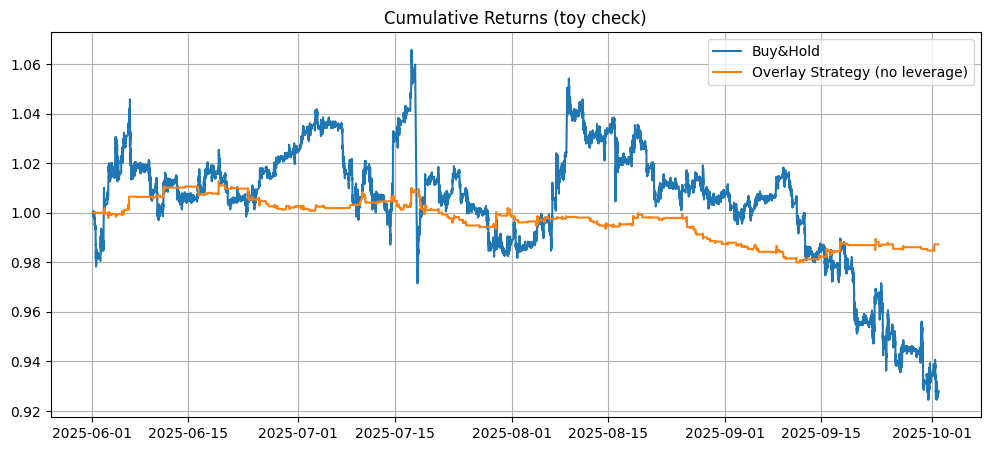

In [40]:
df = df_out.copy()
df = df.sort_values('time').reset_index(drop=True)

# Доходности (по close→close)
df['ret_1'] = df['close'].pct_change()

# Простая схема: если signal==1, считаем, что "держим позицию" на следующий шаг
df['signal_shift'] = df['signal'].shift(1).fillna(0)
df['str_ret'] = df['signal_shift'] * df['ret_1']    # без плеча, для прикидки

bh = (1+df['ret_1'].fillna(0)).cumprod()
st = (1+df['str_ret'].fillna(0)).cumprod()

plt.plot(df['time'], bh, label='Buy&Hold')
plt.plot(df['time'], st, label='Overlay Strategy (no leverage)')
plt.legend()
plt.title('Cumulative Returns (toy check)')
plt.grid(True)
plt.show()
